# Rendimiento de cultivos por municipio

> Datos y gráficos del rendimiento de cultivos por municipio en Bolivia entre 2013 y 2019.

Economías como Bolivia se caracterizan por un sector agrícola poco productivo que ocupa a gran parte de la población. 
La adopción de nuevas tecnologías productivas tiene un enorme potencial de desarrollo.
Cómo ha cambiado la productividad agrícola en Bolivia durante la última década?
En esta nota descargo y grafico datos de producción y superficie cultivada producidos por el Ministerio de Desarrollo Rural y Tierras y publicados por el Ministerio de Desarrollo Productivo y Economía Plural en el [Sistema Integrado de Información Productiva](https://siip.produccion.gob.bo/repSIIP2/formulario_mdryt2.php).

Primero construyo el set de datos, asegurándome que cada valor tenga la forma correcta y atributos como municipios estén harmonizados para realizar comparaciones rápidamente con otros sets de datos:

In [249]:
# Dependencias generales

import requests
import pandas as pd
from IPython.display import clear_output, display, Markdown
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
plt.style.use('estilos/estilo.mplstyle')

# Funciones para descarga de datos

def print_clear(text):
    clear_output(wait=True)
    print(text)

def get_diccionario():
    """
    
    Descarga una lista del inventario de cultivos
    en la base de datos. Retorna un dataframe donde
    cada fila es un cultivo con sus respectivo grupo
    y códigos para descarga.
    """
    
    grupos = [
        {"codigo": 1, "nombre": "CEREALES"},
        {"codigo": 2, "nombre": "ESTIMULANTES"},
        {"codigo": 7, "nombre": "FORRAJES"},
        {"codigo": 3, "nombre": "FRUTALES"},
        {"codigo": 4, "nombre": "HORTALIZAS"},
        {"codigo": 5, "nombre": "INDUSTRIALES"},
        {"codigo": 6, "nombre": "TUBÉRCULOS"},
    ]

    datos = []
    
    for grupo in grupos:

        response = requests.post(
            "https://siip.produccion.gob.bo/repSIIP2/JsonAjaxAgricolaMdryt.php",
            data={"grupo": str(grupo['codigo']), "flag": "cultivo"},
        )
        grupodf = pd.DataFrame(response.json())
        grupodf.columns = ['cultivo_codigo', 'cultivo']
        grupodf.insert(0, 'grupo', grupo['nombre'].lower())
        grupodf.insert(0, 'grupo_codigo', grupo['codigo'])
        datos.append(grupodf)
    
    datos = pd.concat(datos)
    datos[['grupo_codigo', 'cultivo_codigo']] = datos[['grupo_codigo', 'cultivo_codigo']].astype(int)
    for col in ['grupo', 'cultivo']:
        datos[col] = datos[col].str.lower()
        
    return datos

def get_cultivo(dict_row):
    """
    Descarga datos de producción y superficie en cada
    año y municipio disponibles para un cultivo dentro 
    del diccionario de cultivos. Retorna un dataframe
    donde cada fila es información para un año y 
    municipio. 
    """

    departamentos = [
        {"codigo": 7, "nombre": "Santa Cruz"},
        {"codigo": 5, "nombre": "Potosi"},
        {"codigo": 3, "nombre": "Cochabamba"},
        {"codigo": 1, "nombre": "Chuquisaca"},
        {"codigo": 2, "nombre": "La Paz"},
        {"codigo": 6, "nombre": "Tarija"},
        {"codigo": 4, "nombre": "Oruro"},
        {"codigo": 9, "nombre": "Pando"},
        {"codigo": 8, "nombre": "Beni"},
    ]

    datos = []

    for year in range(2013, 2020):

        for dep in departamentos:

            data = {
                "flag": "departamentalMunicipalJson",
                "grupo": str(dict_row["grupo_codigo"]),
                "cultivo": str(dict_row["cultivo_codigo"]),
                "departamento": str(dep["codigo"]),
                "campania": str(year),
            }

            print_clear(data)

            response = requests.post(
                "https://siip.produccion.gob.bo/repSIIP2/JsonAjaxAgricolaMdryt.php",
                data=data,
            )

            if response.status_code == 200 and response.json() != None:

                cultivo_item = pd.DataFrame(response.json())
                cultivo_item.insert(0, "cultivo", dict_row["cultivo"])
                cultivo_item.insert(0, "cultivo_codigo", dict_row["cultivo_codigo"])
                cultivo_item.insert(0, "grupo", dict_row["grupo"])
                cultivo_item.insert(0, "grupo_codigo", dict_row["grupo_codigo"])
                cultivo_item.insert(0, "departamento", dep["nombre"])
                cultivo_item.insert(0, "departamento_codigo", dep["codigo"])
                cultivo_item.insert(0, "year", year)

                datos.append(cultivo_item)

            else:

                errors.append({"data": data, "response": response})

    return pd.concat(datos)

def format_cultivos(cultivos):
    """
    Concatena una lista de dataframes de cultivo y 
    da forma a sus valores para posterior análisis.
    """
    
    def ine(cod):
        cod = str(cod).strip()
        if len(cod) == 3:
            return cod[0] + "0" + cod[1] + "0" + cod[2]
        elif len(cod) == 4:
            return cod[0:2] + cod[2] + "0" + cod[3]

    df = pd.concat(cultivos)
    df = df[[col for col in df.columns if '2' not in col]]
    df[['produccion', 'superficie']] = df[['produccion', 'superficie']].astype(int)
    df['cod_ine'] = df.municipio.apply(lambda x: ine(x))
    return df

# # Descargo la lista de cultivos disponibles
# diccionario = get_diccionario()

# # Descargo datos de producción y superficie de cultivos para cada año y municipio disponibles
# errors = []
# cultivos = []
# for i, row in diccionario.iterrows():
#     cultivos.append(get_cultivo(row))

# # Limpio, formateo y guardo datos
# cultivos_df = format_cultivos(cultivos)
# cultivos_df.to_csv("data/cultivos_all.csv", index=False)
# cultivos_df[
#     [
#         "year",
#         "departamento",
#         "grupo",
#         "cultivo",
#         "cod_ine",
#         "desc_mun",
#         "produccion",
#         "superficie",
#     ]
# ].to_csv("data/cultivos.csv", index=False)

Para tener una vista rápida, produzco una gráfica de cómo cambia el rendimiento de cada cultivo a través de todos los municipios donde se produce. Es posible observar cómo el rendimiento en cada cultivo tiene un comportamiento particular, y cómo algunos municipios mantienen una clara ventaja comparativa a través del periodo.

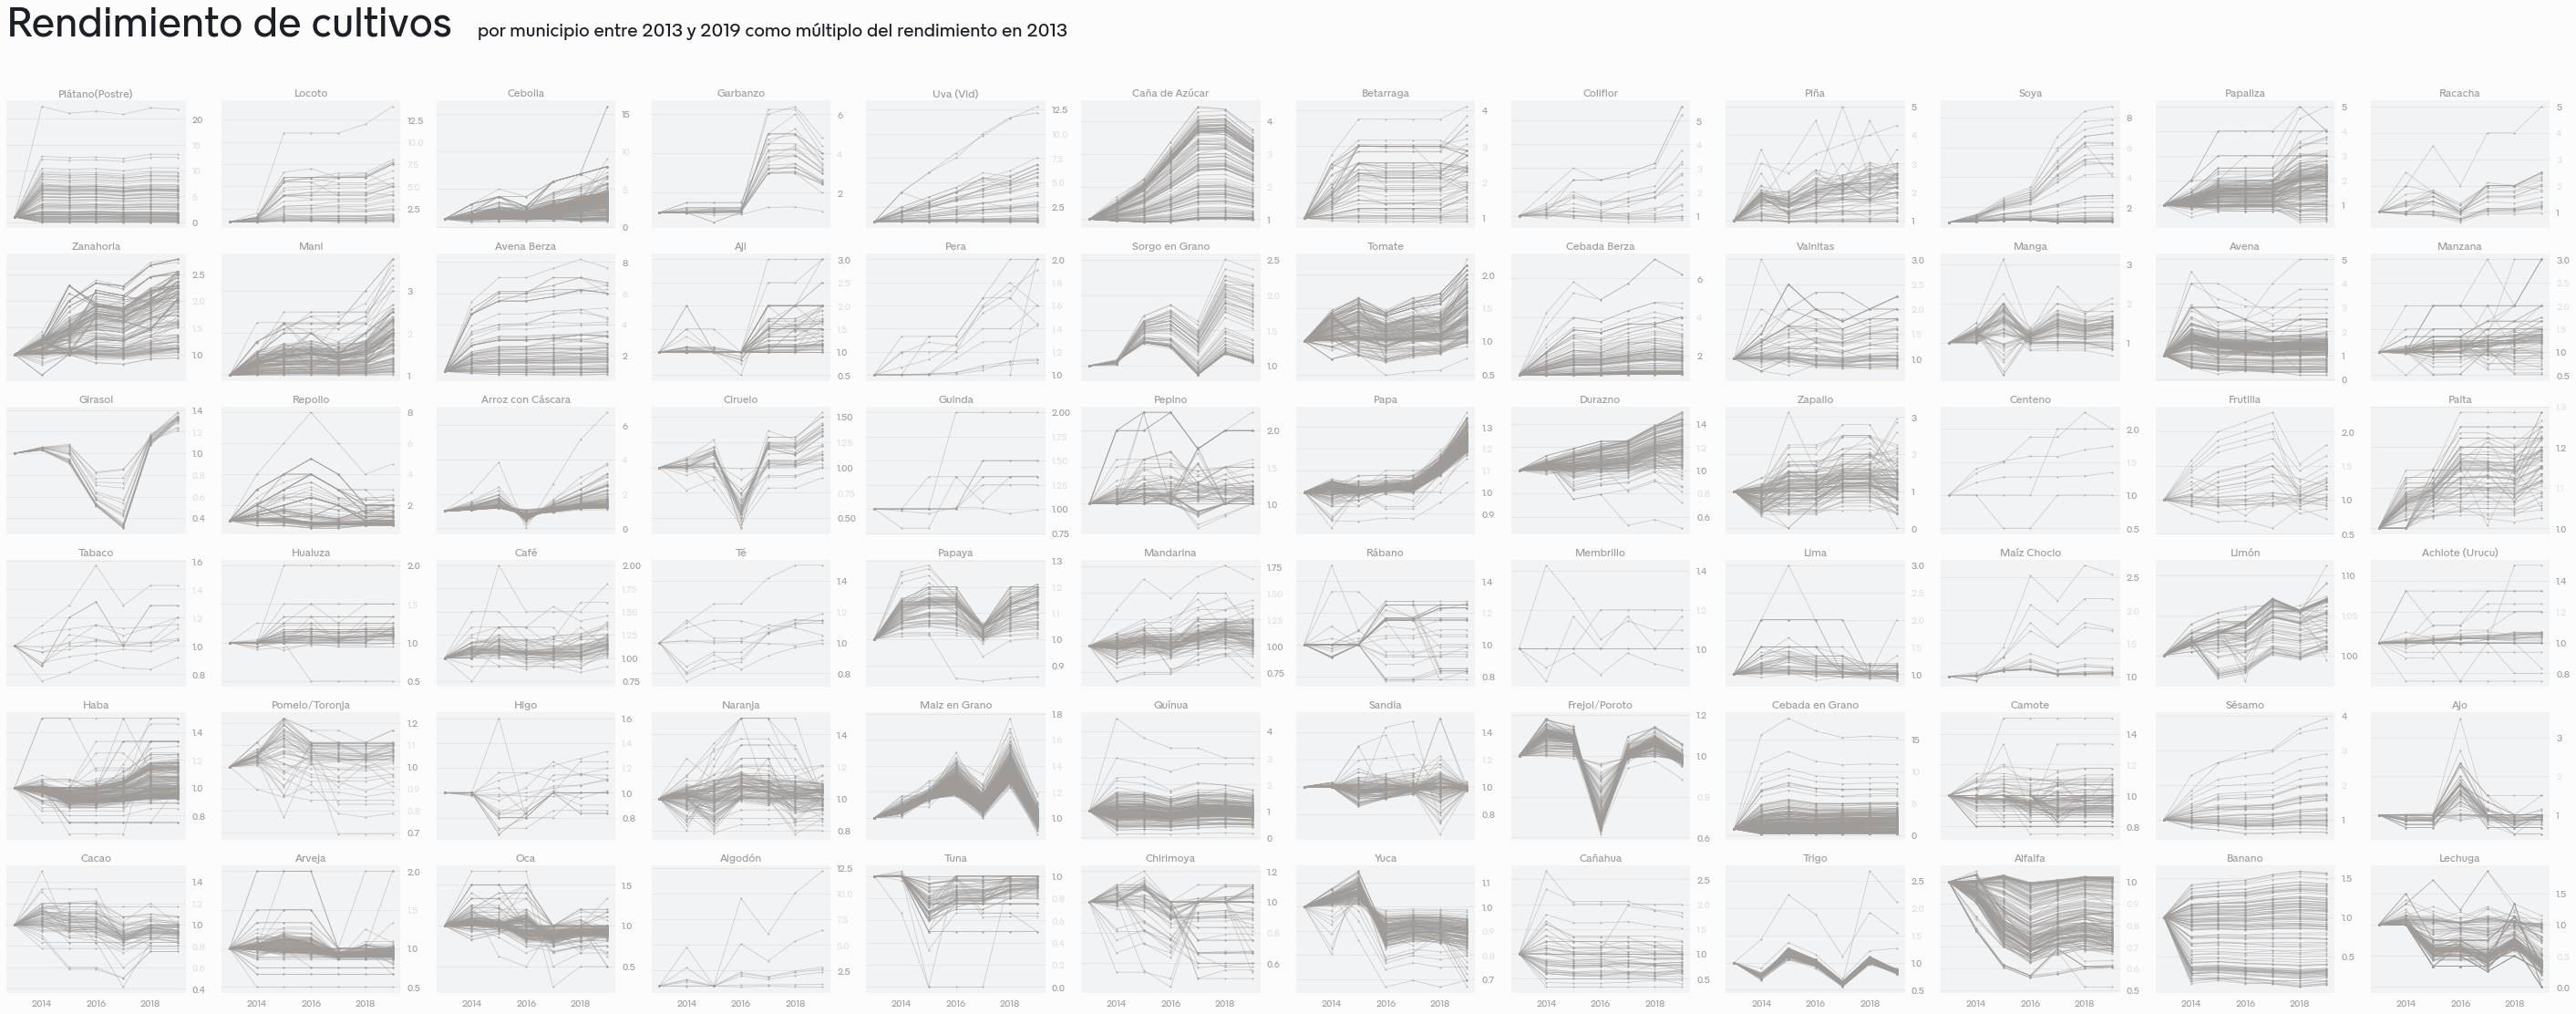

<p class="caption"> <em>Rendimiento por cultivos por municipio entre 2013 y 2019 como múltiplo del rendimiento en 2013 (<a href="https://github.com/mauforonda/notas/raw/main/plots/rendimiento_cultivos_2013_2019.png">imagen en alta resolución</a>) </em> </p>

In [254]:
def caption(text, filename):
    display(Markdown('<p class="caption"> <em>{} (<a href="https://github.com/mauforonda/notas/raw/main/{}">imagen en alta resolución</a>) </em> </p>'.format(text, filename)))

def plot_cultivo_municipio(municipio, cultivo):
    """
    Crea un gráfico comparativo entre la producción 
    y superficie cultivada  para un cultivo en un municipio
    """
    
    linecolor = '#88888f'
    titlecolor = '#1d1f26'
    background = '#fcfcfc'
    
    color_produccion = '#f59b42'
    color_superficie = '#423e3a'
    
    f, ax = plt.subplots(1,1,figsize=(10,5))
    f.set_facecolor(background)
    
    dfi = c[(c.cod_ine == municipio) & (c.cultivo == cultivo)].set_index('year')
    dfi.produccion = dfi.produccion / dfi.loc[2013, 'produccion']
    dfi.superficie = dfi.superficie / dfi.loc[2013, 'superficie']
    ax.plot(dfi.produccion, color=color_produccion, marker='o')
    ax.plot(dfi.superficie, color=color_superficie, marker='o')
    ax.grid(axis='y')
    ax.tick_params(labelcolor=linecolor)

def plot_cultivo_rendimiento(cultivo, ax):
    """
    Crea un gráfico comparativo entre el rendimiento de un cultivo entre 
    todos los municipios donde está presente como múltiplo del rendimiento
    en 2013
    """
    
    linecolor = '#88888f'
    titlecolor = '#1d1f26'
    color_rendimiento = '#9e9b98'
    
    cultivo_df = c[(c.cultivo == cultivo)]
    for mun, dfi in cultivo_df.groupby('cod_ine'):
        dfi = dfi.set_index('year')
        dfi.rendimiento = dfi.rendimiento / dfi.loc[dfi.index.min(), 'rendimiento'] 
        ax.plot(dfi.rendimiento, color=color_rendimiento, marker='o', alpha=.5, markersize=1.2, linewidth=.7)
    
    ax.grid(axis='y')
    ax.tick_params(labelcolor=color_rendimiento, labelright=True, labelleft=False, labelsize=10)
    ax.annotate(' '.join([word.title() if word not in ['en', 'de', 'con'] else word.lower() for word in cultivo.split()]), xy=(.5,1.02), xycoords='axes fraction', ha='center', va='bottom', fontsize=12, color=color_rendimiento)
    
    last_label = len(ax.get_yticklabels()) - 2
    one = [i for i, tick in enumerate(ax.get_yticks()) if tick == 1.]
    clear_ticks = [1, last_label] + one
    
    for i, label in enumerate(ax.get_yticklabels()):
        if i in clear_ticks:
            label.set_alpha(1.)
        else:
            label.set_alpha(.3)

def get_ranking(c):
    """
    Ordena cultivos por la ganancia de rendimiento en el periodo
    de estudio, de mayor a menor. Excluye entradas donde el rendimiento 
    era muy pequeño en 2013, que usualmente apuntan a casos donde no había 
    producción.
    """
    
    df = pd.DataFrame({i:{'year_min': dfi.year.min(), 'year_max': dfi.year.max(), 'rendimiento_min': dfi[dfi.year == dfi.year.min()].rendimiento.iloc[0], 'rendimiento_max': dfi[dfi.year == dfi.year.max()].rendimiento.iloc[0]} for i, dfi in c.groupby(['cod_ine', 'cultivo'])}).T
    df.replace(0, .001, inplace=True)
    df['rendimiento_diff'] = df.rendimiento_max / df.rendimiento_min
    df = df.reset_index().rename(columns={'level_0': 'cod_ine', 'level_1':'cultivo'})
    return df[df.rendimiento_min > .5].groupby('cultivo').rendimiento_diff.mean().sort_values(ascending=False).index.tolist()

def plot_cultivos(c):
    """
    Crea un gráfico comparativo para el rendimiento de cada
    cultivo como múltiplo del rendimiento en 2013, ordenado
    de mayor a menor ganancia de rendimiento.
    """
    
    filename = 'plots/rendimiento_cultivos_2013_2019.png'
    ranking = get_ranking(c)

    titlecolor = '#1d1f26'
    color_rendimiento = '#9e9b98'

    f, axs = plt.subplots(6,12,figsize=(50,18), sharex=True)
    f.set_facecolor('#fcfcfc')
    f.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.flatten()
    for cultivo, ax in zip(ranking, axs):
        plot_cultivo_rendimiento(cultivo, ax)

    axs[0].annotate('Rendimiento de cultivos', xy=(0.0, 1.45), xycoords='axes fraction', fontsize=45, color=titlecolor, ha='left', va='bottom',)
    axs[2].annotate('por municipio entre 2013 y 2019 como múltiplo del rendimiento en 2013', xy=(.23, 1.48), xycoords='axes fraction', fontsize=20, color=titlecolor, ha='left', va='bottom',)
    plt.savefig(filename, bbox_inches='tight', pad_inches=.4, dpi=200)
    plt.show()
    caption('Rendimiento por cultivos por municipio entre 2013 y 2019 como múltiplo del rendimiento en 2013', filename)
    
c = pd.read_csv('data/cultivos.csv')
c = c[c.superficie != 0]
c['rendimiento'] = c.produccion / c.superficie
plot_cultivos(c)